*Mihaela Dimovska, EE8950, Notebook for Progress Report*

Project: Re-implementing the SNN model for digit classification in *Spiking neural networks for handwritten digit
recognition—Supervised learning and network optimization*, Shruti R. Kulkarni, Bipin Rajendran, NN 2018

Recall the **Integrate and Fire model**, where only weights at time $t$ were included:


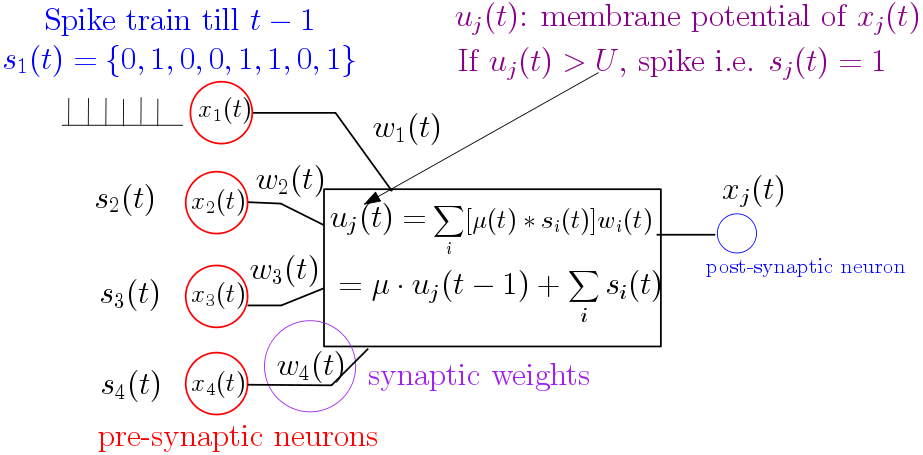

In [1]:
from IPython.display import Image
fig = Image(filename=('img/neuron_model.png'))
fig

In this paper, the memberane potential $V(t)$ is calculated as: $C \frac{dV(t)}{dt} = −g_{L}\cdot(V(t) − EL) + Isyn(t)$<br>
$C=300pF$ and $g_{L} = 30ns$ model the membrane’s capacitance and leak conductance, respectively<br>
$EL = −70mV$ is the resting potential<br>
The threshold for firing is $VT=20mV$ (i.e. if $V(t) \geq VT$ emit a spike)<br>
Biological neurons enter a refractory period immediately after a 
spike is issued during which another spike cannot be issued. This is
implemented by holding the membrane potential at $V(t) = EL$
for a short **refractory** period $tref = 3ms$ after the issue of a spike.<br>
$I_{syn}$ is an input current from a synapse (from a pre-synaptic neuron)

To implement the calculation of the membrane potential at time $t+1$ we can use Euler's forward method:
$V[:,t+1] = V[:,i] + dt\cdot((1/capacity)\cdot(I_{syn}-(V[:,t]-EL))))$

In [54]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt 
import pickle

#The hyperparameters explained above and their initial values as given in the paper
capacity = 300e-12
gL = 30E-9
EL = -70e-3
VT = 20e-3
tref = 3e-3 # refractory period

Now, let's convert each pixel to a spike train of length $1000$.Thus, we need to get $256x1000$ matrix at the end. 

In [55]:

T = 0.1 # duration of simulation
dt = 0.1e-3 #time step
M = int(T//dt) #number of time-steps
t = np.arange(0, T, dt) #time time-series

In [56]:
#Declare the pixel array
N_pixel = 256
pix = np.array([i for i in range(N_pixel)])
pix = np.transpose(pix)
print(pix.shape)

(256,)


Ech pixel value k is converted into a constant input current for the LIF neuron as<br>
$I_{in}(k) = I_0 +(k × Ip)$ <br>
where $I_0 = 2700pA$ and $Ip = 101.2 pA$<br>
$I_{in}$ becomes input current to every neuron<br>

In [45]:
Ip = 1.012e-10
I_0 = 2.7e-9 
I_in = I_0 + pix * Ip

In [57]:
#matrix that stores the membrane potential for every neuron (we have a neuron for each pixel) at every time
V = np.zeros([N_pixel, M+1])
#matrix that stores the spike-train for every neuron
Y_spk = np.zeros([N_pixel, M])
#array that indicates if a neuron is in refractory period
is_neuron_in_ref= np.zeros([N_pixel, 1])

In [58]:
#with this code, essentially we calculate the spike trains given input current train
#at every time step i (up to time step M)
for i in range(M):
    #use Forward Euler to calculate the memberane potential of each pixel at time i+1
    V[:,i+1] = V[:,i] + dt*((1/capacity)*(I_in-(gL*(V[:,i]-EL))))
    #this statement is necessary here to tell us that every neuron starts at resting potential
    V[np.where(t[i] - is_neuron_in_ref < tref), i+1] = EL
    spike_index = []
    for neuron in range(V[:,i+1].shape[0]):
        if V[neuron,i+1]-VT > 0:
            spike_index.append(1)
        else:
            spike_index.append(0)
    spike_index = np.asarray(spike_index)
    if max(spike_index)>0:
        spiked_neuron = np.where(spike_index>0)
        #the spiked neuron needs to be put in refractory period, 
        #essentially 3 time steps need to pass for the neurons potential at future times
        #to be greater than the resting potential EL
        is_neuron_in_ref[spiked_neuron] = t[i]
        #but at this time step, the potential is VT
        V[spiked_neuron, i] = VT
        Y_spk[spiked_neuron, i] = 1

<IPython.core.display.Javascript object>


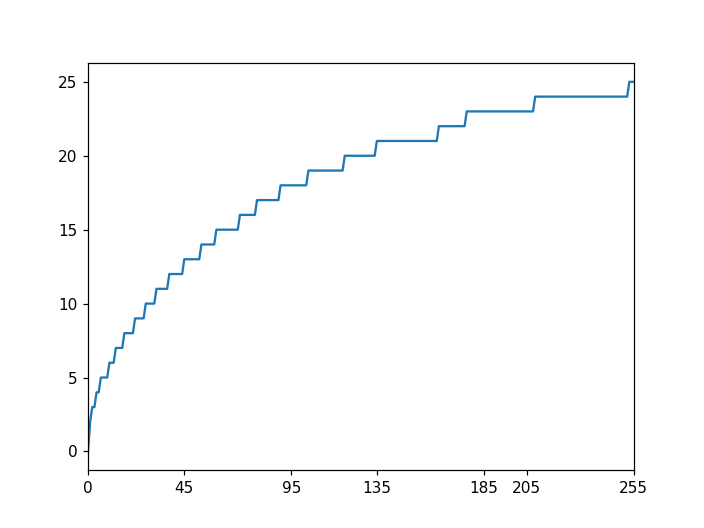

In [59]:
#plot the frequency of the spikes for each pixel
freq = [sum(Y_spk[i,:]) for i in range(256)]
plt.plot([i for i in range(256)], freq)
plt.xlim([0,255])
plt.xticks([0,45,95,135,185,205,255])
plt.show()

<IPython.core.display.Javascript object>


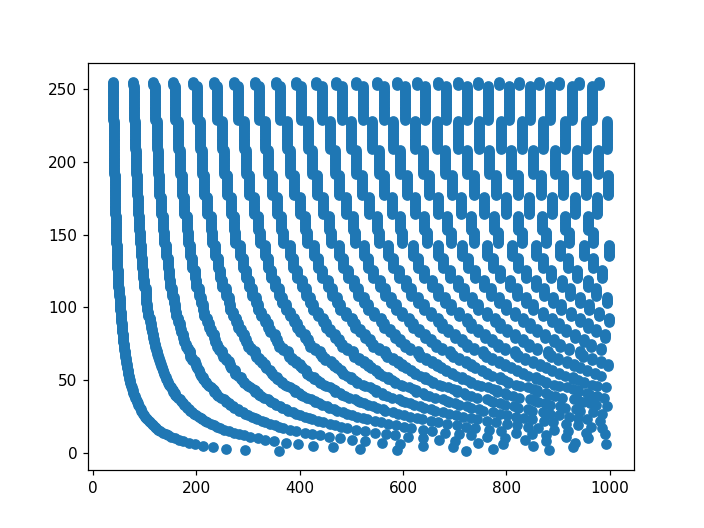

In [60]:
#plot the spike trains of each pixel
[x,y] = np.where(Y_spk)
plt.plot(y,x,'o')
plt.show()

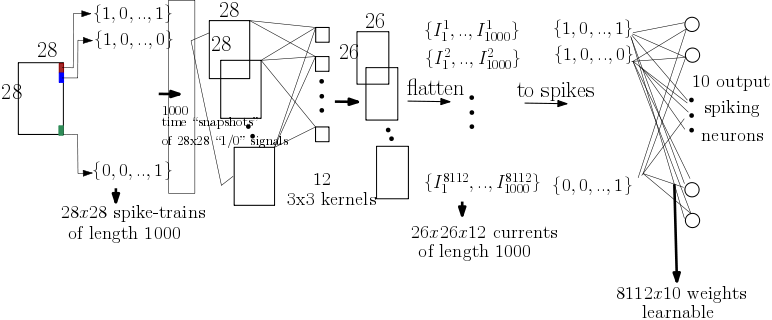

In [61]:
from IPython.display import Image
fig = Image(filename=('img/concepts_2.png'))
fig

From paper: "The filter kernels are spatially convolved with 28 × 28 spike trains<br>
    arriving from the input layer neurons".<br>
    "The spikes from the input layer neurons pass through these synaptic weight kernels<br>
    to generate currents to the hidden layer neurons."
    

Example: A test-sample from the digit 9 is converted to $28x28$ spike-trains of length $1000$<br>
Then, we consider each time-snapshot as input; thus we forward a "batch" of $1000$ spike signals with $28x28$ spatial dimensions <br>
As output, from each of the $1000$ snap shots, we get $12x26x26$ feature maps.<br>
Reshaping this, we get $8112$ **current trains**, $I_{i}(t)$ of length $1000$. 
Before we get to the last layer computations, let's look at the spikes that are generated in the hidden-layer neurons by the current signals $I_{i}(t)$, $i=1,...,8112$, $t=0,...999$. <br>
Having abstracted the method for converting current to spikes, (you can find it in **current_to_spikes.py**), we forward the currents to that method; we get the spikes (a matrix of dimensions $8112x1000$ ).<br>
**Reshaping this matrix to a tensor of $12x26x26x1000$ and summing accross the last dimension, we can visualize the number of spikes each kernel induced.** <br>
Below is a vizualization of the number of spikes induced by one of the kernels on a sample-digit. The code for this vizualization is in the script **sample_forward_pass_till_hidden_layer.py**

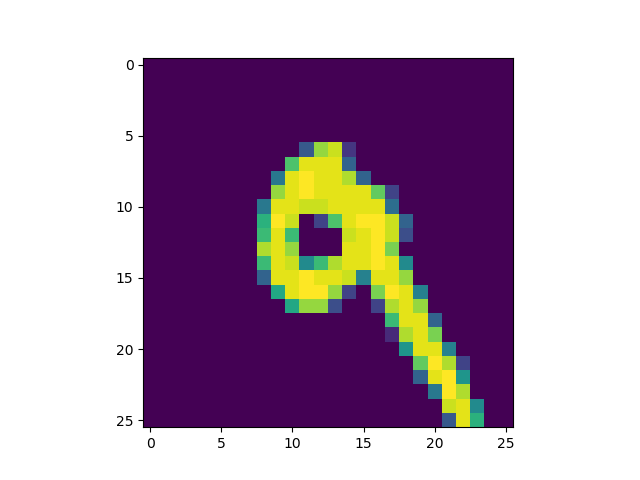

In [51]:
from IPython.display import Image
fig = Image(filename=('img/spikes_viz_9.png'))
fig

Now, once we have the spike trains from the hidden layer, we can calculate the synaptic kernels for every hidden neuron by using <br>
$c(t)=\sum_{i}\delta(t-t^{i})*(e^{-t/\tau_1} − e^{−t/\tau_2})$<br>
with $\tau_1=5ms$, $\tau_2=1.25ms$.<br>
The equation above, written more clearly, actually does the following at every time-step $t$ when there is a spike: <br>
$(e^{-1/\tau_1} − e^{−1/\tau_2})*c(t-1) + 1 $<br>
The script **from_hidden_spikes_to_current_for_outputs.py** implements a function that does exactly what the script title says: converts the spikes-trains of the $8112$ hidden spiking neurons to input current for the output neurons, where the current of the hidden neurons is calculated as $I_{syn}(t) = w \cdot c(t)$. 

In the script **forward_step_one_sample.py** the full forward-step with classification outcome is presented. <br>
Steps that are taken in that script are essentially:<br>
1) From pixels (input neurons) to spike trains of those input neurons<br>
2) From the spike trains of the input neurons to current for the 8112 hidden neurons (using conv. filters)<br>
3) From the input current to the hidden neurons, get the spike trains of the hidden neurons<br>
4) The spike trains of the hidden neurons generate current to the 10 output neurons **(here we use the weights and the synaptic kernels!)** <br>
5) From the input current to the output neurons, get the spike trains of the output neurons<br>
6) Based on which output neuron has the highest number of spikes, classify


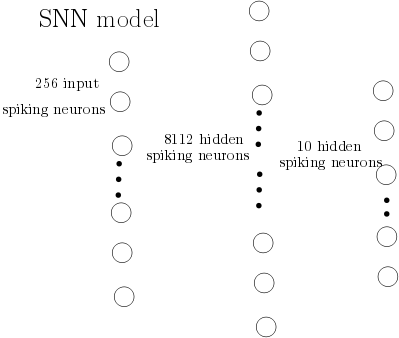

In [52]:
from IPython.display import Image
fig = Image(filename=('img/snn_model.png'))
fig

TODO:<br> 
1) generate the desired spike train for the digits and calculate the error from the output spike train for that particular digit<br>
2) Back-propagate the error<br>
3) Try to learn one digit<br>
